# Setup

## Mount Drive

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [6]:
%ls

drive/  sample_data/


In [7]:
%ls drive/My\ Drive/projects/deep_learning_school/15_Image_Segmentation/

 15_Image_Segmentation@                 prepod_mak.jpg
'Copy of [seminar]segmentation.ipynb'   segnet_best.h5
 data@                                  segnet_last.h5
 fcn.jpg                                segnet.png
 fcn_last.h5                            unet.png
 prepod.jpg                             unet_resnet_strucutre_new.png


In [8]:
%cd drive/My\ Drive/projects/deep_learning_school/15_Image_Segmentation/
%ls

/content/drive/My Drive/projects/deep_learning_school/15_Image_Segmentation
 15_Image_Segmentation@                 prepod_mak.jpg
'Copy of [seminar]segmentation.ipynb'   segnet_best.h5
 data@                                  segnet_last.h5
 fcn.jpg                                segnet.png
 fcn_last.h5                            unet.png
 prepod.jpg                             unet_resnet_strucutre_new.png


## Imports and utility functions

In [9]:
import numpy as np
import pandas as pd

import cv2
import matplotlib.pyplot as plt

In [9]:
def rle_decode(mask_rle, shape=(1280, 1918, 1)):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return 
    Returns numpy array, 1 - mask, 0 - background
    '''
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)

    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths    
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
        
    img = img.reshape(shape)
    return img

## Load Data

In [10]:
df = pd.read_csv('data/train_masks.csv')
df.shape

(5088, 2)

In [11]:
df.head()

,img,rle_mask
0,00087a6bd4dc_01.jpg,879386 40 881253 141 883140 205 885009 17 8850...
1,00087a6bd4dc_02.jpg,873779 4 875695 7 877612 9 879528 12 881267 15...
2,00087a6bd4dc_03.jpg,864300 9 866217 13 868134 15 870051 16 871969 ...
3,00087a6bd4dc_04.jpg,879735 20 881650 26 883315 92 883564 30 885208...
4,00087a6bd4dc_05.jpg,883365 74 883638 28 885262 119 885550 34 88716...


In [12]:
train_df = df[:4000]
val_df = df[4000:]

In [13]:
img_name, mask_rle = train_df.iloc[4]

img = cv2.imread(f'data/train/{img_name}')
mask = rle_decode(mask_rle)

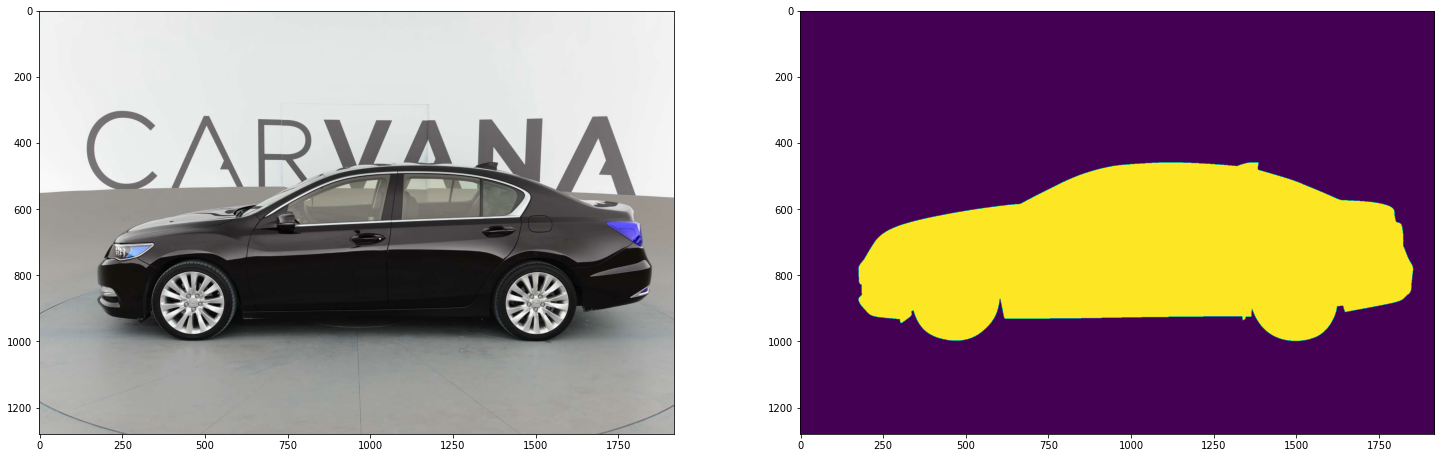

In [14]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(25, 25))
axes[0].imshow(img)
axes[1].imshow(mask[..., 0])

plt.show()

In [15]:
def batch_generator(gen_df, batch_size):
    while True:
        x_batch = []
        y_batch = []
        
        for i in range(batch_size):
            img_name, mask_rle = gen_df.sample(1).values[0]
            img = cv2.imread('data/train/{}'.format(img_name))
            mask = rle_decode(mask_rle)
            
            img = cv2.resize(img, (256, 256))
            mask = cv2.resize(mask, (256, 256))
            
            
            x_batch += [img]
            y_batch += [mask]

        x_batch = np.array(x_batch) / 255.
        y_batch = np.array(y_batch)

        yield x_batch, np.expand_dims(y_batch, -1)

In [16]:
for x, y in batch_generator(train_df, 16):
    break

In [17]:
x.shape
# channel last (RGB image, so 3 channels)

(16, 256, 256, 3)

In [18]:
y.shape
# 1 channel of the output

(16, 256, 256, 1)

# Image Segmentation with Deep Neural Nets 

In [19]:
# TODO: put all imports here

## Layer examples

In [20]:
# UpSampling2D(size=(32, 32), interpolation='bilinear')(layer)
# Conv2D(1, (1,1), strides=(1, 1))(layer)
# Conv2D(256, (3,3), padding='same')(layer)
# Activation('relu')(layer)
# Concatenate(axis=-1)([layer_1, layer_2])

## FCN

In [21]:
%ls

 15_Image_Segmentation@                 prepod_mak.jpg
'Copy of [seminar]segmentation.ipynb'   segnet_best.h5
 data@                                  segnet_last.h5
 fcn.jpg                                segnet.png
 fcn_last.h5                            unet.png
 prepod.jpg                             unet_resnet_strucutre_new.png


(433, 877, 3)
(433, 877, 3)


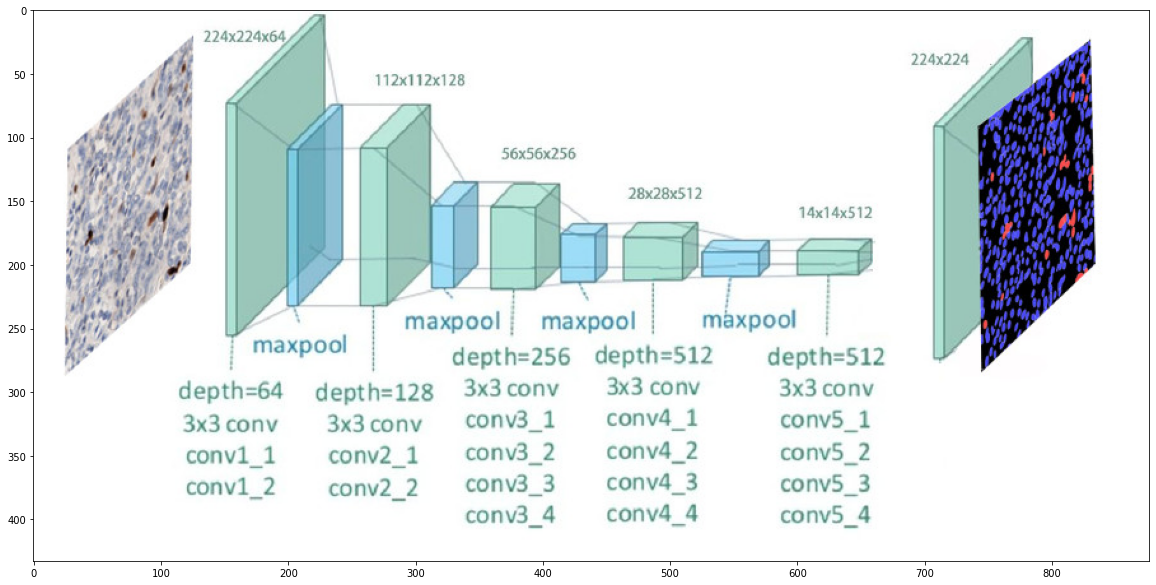

In [22]:
fcn_png = cv2.imread('fcn.jpg')
plt.figure(figsize=(20,20))
print(fcn_png.shape)
plt.imshow(fcn_png[..., [2,1,0]]) # want [channel, width, hight] instead of [hight, width, channel]
print(fcn_png[..., [2, 1, 0]].shape)
plt.show()

In [23]:
# works after tensorflow 2.0 release
#
import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.resnet50 import ResNet50

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Activation
from tensorflow.keras.layers import Dropout, BatchNormalization
from tensorflow.keras.layers import MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.layers import Conv2D, UpSampling2D, Concatenate

# old keras imports
#
# import keras
# from keras.applications.resnet50 import ResNet50
# from keras.applications.vgg16 import VGG16
# from keras.models import Model
# from keras.layers import Dense, GlobalAveragePooling2D, Dropout, UpSampling2D, Conv2D, MaxPooling2D, Activation, Concatenate, BatchNormalization


base_model = VGG16(weights='imagenet', # weights pretrained on imagenet
                   input_shape=(256, 256, 3), 
                   include_top=False # throw away fully connected layers
                   )

base_out = base_model.output
print(base_out.shape)
# [bacth_size, 256, 256, 3] - input size
# [batch_size, 8, 8, 512] - current output size 
# 256 / 6 = 32


# so we want to upscale 32 times
up = UpSampling2D(32, interpolation='bilinear')(base_out)
print(up.shape)
# current output size: batch_size, 256, 256, 512


# now we have 512 channels, whereas for binary classification of a pixel we really 
# only want one channel, so we use 1*1 convolution with 1 output channel
conv = Conv2D(1, (1, 1))(up)
print(conv.shape)
# current output size [batch_size, 256, 256, 1], range - all reals

# we use sigmoid activation on each pixel toconvert floats of any size into probabilities
conv = Activation('sigmoid')(conv)

# we create a model object
model = Model(inputs=base_model.input, outputs=conv)

58892288/58889256 [==============================] - 1s 0us/step
(None, 8, 8, 512)
(None, 256, 256, 512)
(None, 256, 256, 1)


In [24]:
base_out

<tf.Tensor 'block5_pool/MaxPool:0' shape=(None, 8, 8, 512) dtype=float32>

In [25]:
up

<tf.Tensor 'up_sampling2d/resize/ResizeBilinear:0' shape=(None, 256, 256, 512) dtype=float32>

In [26]:
256/8

32.0

In [27]:
pred = model.predict(x)

In [28]:
pred.shape

(16, 256, 256, 1)

In [29]:
cv2.resize(pred[0, :, :, 0], (256, 256)).shape

(256, 256)

In [30]:
best_w = keras.callbacks.ModelCheckpoint('fcn_best.h5',
                                monitor='val_loss',
                                verbose=0,
                                save_best_only=True,
                                save_weights_only=True,
                                mode='auto',
                                save_freq='epoch')

last_w = keras.callbacks.ModelCheckpoint('fcn_last.h5',
                                monitor='val_loss',
                                verbose=0,
                                save_best_only=False,
                                save_weights_only=True,
                                mode='auto',
                                save_freq='epoch')


callbacks = [best_w, last_w]


adam = keras.optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)


model.compile(adam, 'binary_crossentropy')

In [31]:
batch_size = 16
model.fit(
    batch_generator(train_df, batch_size),
    steps_per_epoch=100,
    epochs=3,
    verbose=1,
    callbacks=callbacks,
    validation_data=batch_generator(val_df, batch_size),
    validation_steps=50,
    class_weight=None,
    max_queue_size=10,
    workers=-1,
    use_multiprocessing=False,
    shuffle=True,
    initial_epoch=0
)

Epoch 1/3
  1/100 [..............................] - ETA: 0s - loss: 0.6335

KeyboardInterrupt: ignored

In [32]:
pred = model.predict(x)#.shape

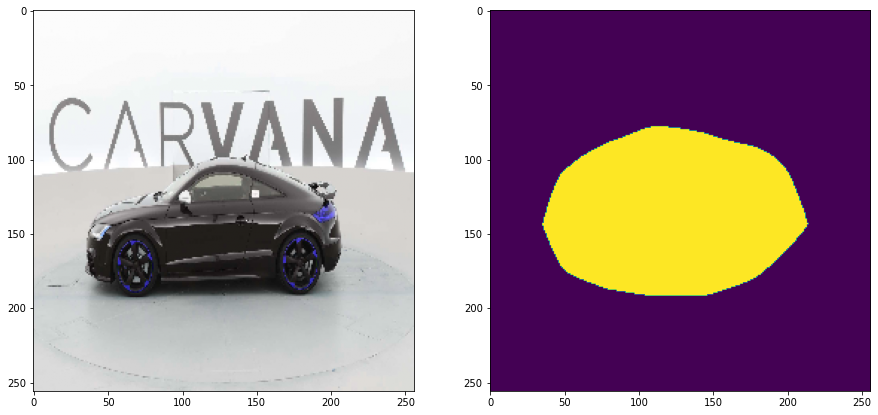

In [33]:
im_id = 13
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 15))
axes[0].imshow(x[im_id])
axes[1].imshow(pred[im_id, ..., 0] > 0.5)

plt.show()

## SegNet

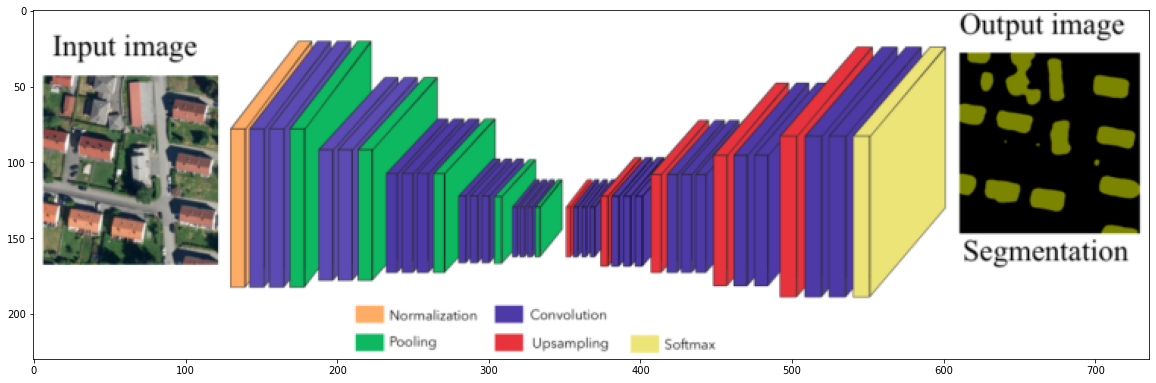

In [34]:
seg_png = cv2.imread('segnet.png')
plt.figure(figsize=(20,20))
plt.imshow(seg_png[..., [2,1,0]])
plt.show()

In [35]:
# from keras.models import Model
# from keras.layers import Input, Dense
# from keras.layers import Dense, GlobalAveragePooling2D, Dropout, UpSampling2D, Conv2D, MaxPooling2D

# input
inp = Input(shape=(256, 256, 3))

# encoder block 1
conv_1_1 = Conv2D(32, (3, 3), padding='same')(inp)
conv_1_1 = Activation('relu')(conv_1_1)

conv_1_2 = Conv2D(32, (3, 3), padding='same')(conv_1_1)
conv_1_2 = Activation('relu')(conv_1_2)

pool_1 = MaxPooling2D(2)(conv_1_2)

# encoder block 2
conv_2_1 = Conv2D(64, (3, 3), padding='same')(pool_1)
conv_2_1 = Activation('relu')(conv_2_1)

conv_2_2 = Conv2D(64, (3, 3), padding='same')(conv_2_1)
conv_2_2 = Activation('relu')(conv_2_2)

pool_2 = MaxPooling2D(2)(conv_2_2)

# encoder block 3
conv_3_1 = Conv2D(128, (3, 3), padding='same')(pool_2)
conv_3_1 = Activation('relu')(conv_3_1)

conv_3_2 = Conv2D(128, (3, 3), padding='same')(conv_3_1)
conv_3_2 = Activation('relu')(conv_3_2)

pool_3 = MaxPooling2D(2)(conv_3_2)

# encoder block 4
conv_4_1 = Conv2D(256, (3, 3), padding='same')(pool_3)
conv_4_1 = Activation('relu')(conv_4_1)

conv_4_2 = Conv2D(256, (3, 3), padding='same')(conv_4_1)
conv_4_2 = Activation('relu')(conv_4_2)

pool_4 = MaxPooling2D(2)(conv_4_2)


# decoder block 1
up_1 = UpSampling2D(2, interpolation='bilinear')(pool_4)

conv_up_1_1 = Conv2D(256, (3, 3), padding='same')(up_1)
conv_up_1_1 = Activation('relu')(conv_up_1_1)

conv_up_1_2 = Conv2D(256, (3, 3), padding='same')(conv_up_1_1)
conv_up_1_2 = Activation('relu')(conv_up_1_2)


# decoder block 2
up_2 = UpSampling2D(2, interpolation='bilinear')(conv_up_1_2)

conv_up_2_1 = Conv2D(128, (3, 3), padding='same')(up_2)
conv_up_2_1 = Activation('relu')(conv_up_2_1)

conv_up_2_2 = Conv2D(128, (3, 3), padding='same')(conv_up_2_1)
conv_up_2_2 = Activation('relu')(conv_up_2_2)

# decoder block 3
up_3 = UpSampling2D(2, interpolation='bilinear')(conv_up_2_2)

conv_up_3_1 = Conv2D(64, (3, 3), padding='same')(up_3)
conv_up_3_1 = Activation('relu')(conv_up_3_1)

conv_up_3_2 = Conv2D(64, (3, 3), padding='same')(conv_up_3_1)
conv_up_3_2 = Activation('relu')(conv_up_3_2)


# decoder block 4
up_4 = UpSampling2D(2, interpolation='bilinear')(conv_up_3_2)
conv_up_4_1 = Conv2D(32, (3, 3), padding='same')(up_4)
conv_up_4_1 = Activation('relu')(conv_up_4_1)

conv_up_4_2 = Conv2D(1, (3, 3), padding='same')(conv_up_4_1)
# we skip relu activation here since we will have nonlinearity with sigmoid anyway


# result
result = Activation('sigmoid')(conv_up_4_2)


# model all together
model = Model(inputs=inp, outputs=result)

In [36]:
conv_up_4_1

<tf.Tensor 'activation_15/Relu:0' shape=(None, 256, 256, 32) dtype=float32>

In [37]:
conv_1_1

<tf.Tensor 'activation_1/Relu:0' shape=(None, 256, 256, 32) dtype=float32>

In [38]:
best_w = keras.callbacks.ModelCheckpoint('segnet_best.h5',
                                monitor='val_loss',
                                verbose=0,
                                save_best_only=True,
                                save_weights_only=True,
                                mode='auto',
                                save_freq='epoch')

last_w = keras.callbacks.ModelCheckpoint('segnet_last.h5',
                                monitor='val_loss',
                                verbose=0,
                                save_best_only=False,
                                save_weights_only=True,
                                mode='auto',
                                save_freq='epoch')


callbacks = [best_w, last_w]


adam = keras.optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)


model.compile(adam, 'binary_crossentropy')

In [39]:
batch_size = 16
model.fit(
    batch_generator(train_df, batch_size),
    steps_per_epoch=100,
    epochs=15,
    verbose=1,
    callbacks=callbacks,
    validation_data=batch_generator(val_df, batch_size),
    validation_steps=50,
    class_weight=None,
    max_queue_size=10,
    workers=-1,
    use_multiprocessing=True,
    shuffle=True,
    initial_epoch=0
)

Epoch 1/15


KeyboardInterrupt: ignored

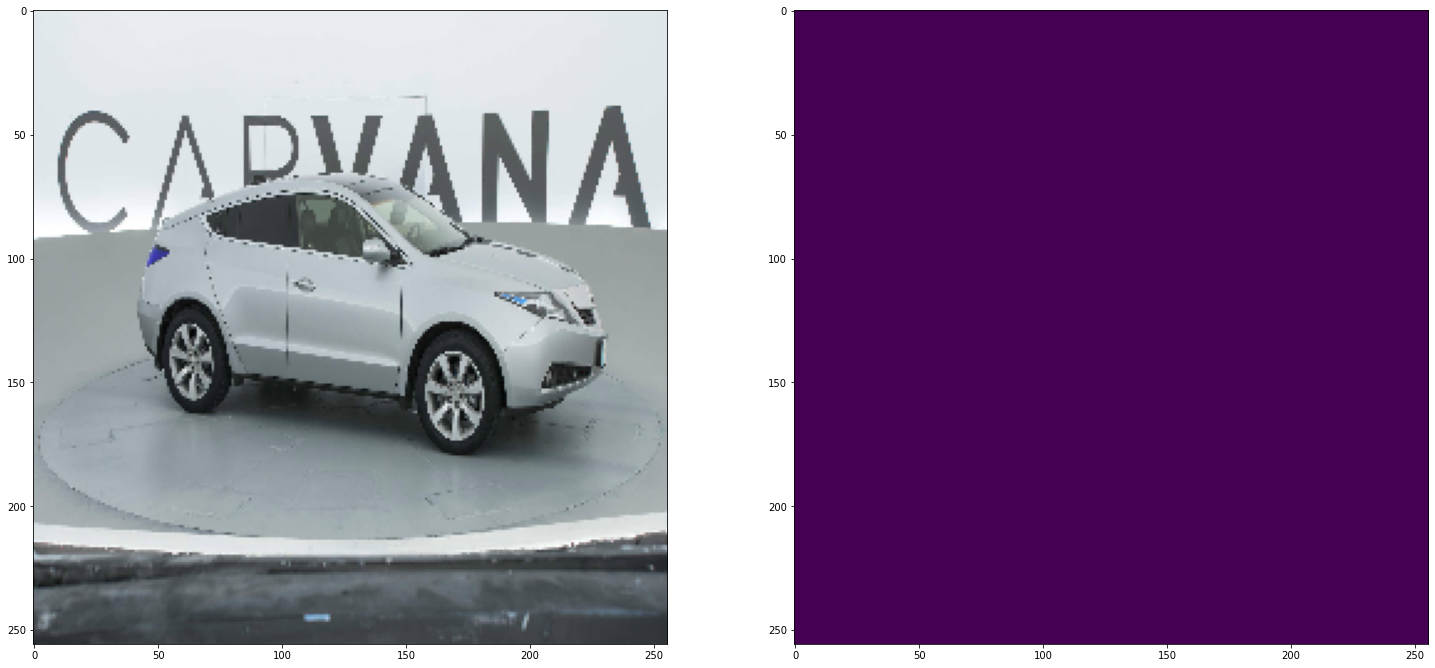

In [40]:
pred = model.predict(x)#.shape

im_id = 14
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(25, 25))
axes[0].imshow(x[im_id])
axes[1].imshow(pred[im_id, ..., 0] > 0.5)

plt.show()

## Vanilla Unet

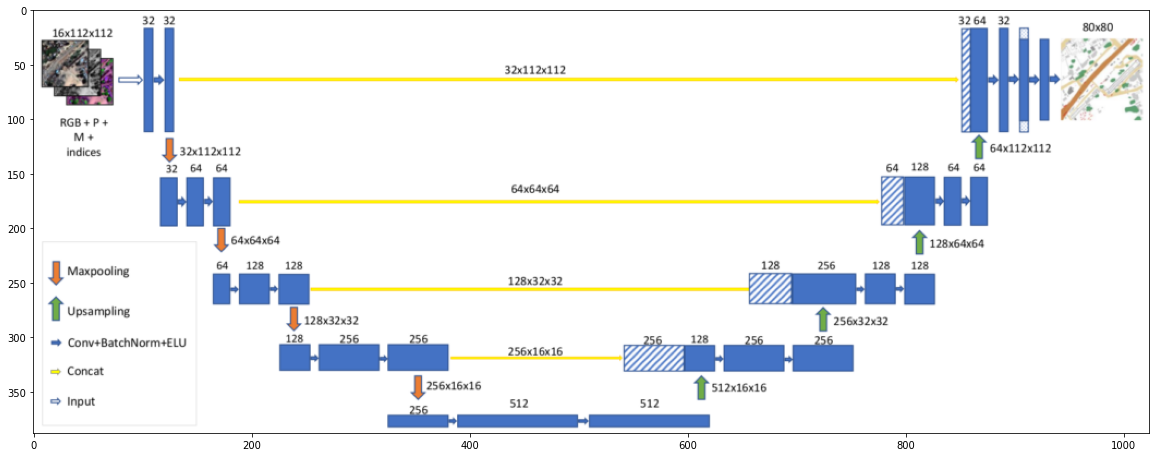

In [41]:
seg_png = cv2.imread('unet.png')
plt.figure(figsize=(20,20))
plt.imshow(seg_png[..., [2,1,0]])
plt.show()

**Note:** we concatenate from before pooling layers to after aupsampling layers.

In [42]:
# from keras.models import Model
# from keras.layers import Input, Dense, Concatenate
# from keras.layers import Dense, GlobalAveragePooling2D, Dropout, UpSampling2D, Conv2D, MaxPooling2D

# input
inp = Input(shape=(256, 256, 3))


# encoding block 1
conv_1_1 = Conv2D(32, (3, 3), padding='same')(inp)
conv_1_1 = Activation('relu')(conv_1_1)

conv_1_2 = Conv2D(32, (3, 3), padding='same')(conv_1_1)
conv_1_2 = Activation('relu')(conv_1_2)

pool_1 = MaxPooling2D(2)(conv_1_2)

# encoding block 2
conv_2_1 = Conv2D(64, (3, 3), padding='same')(pool_1)
conv_2_1 = Activation('relu')(conv_2_1)

conv_2_2 = Conv2D(64, (3, 3), padding='same')(conv_2_1)
conv_2_2 = Activation('relu')(conv_2_2)

pool_2 = MaxPooling2D(2)(conv_2_2)

# encoding block 3
conv_3_1 = Conv2D(128, (3, 3), padding='same')(pool_2)
conv_3_1 = Activation('relu')(conv_3_1)

conv_3_2 = Conv2D(128, (3, 3), padding='same')(conv_3_1)
conv_3_2 = Activation('relu')(conv_3_2)

pool_3 = MaxPooling2D(2)(conv_3_2)

# encoding block 4
conv_4_1 = Conv2D(256, (3, 3), padding='same')(pool_3)
conv_4_1 = Activation('relu')(conv_4_1)

conv_4_2 = Conv2D(256, (3, 3), padding='same')(conv_4_1)
conv_4_2 = Activation('relu')(conv_4_2)

pool_4 = MaxPooling2D(2)(conv_4_2)


# decoding block 1
up_1 = UpSampling2D(2, interpolation='bilinear')(pool_4)
conc_1 = Concatenate()([conv_4_2, up_1]) # concatenation

conv_up_1_1 = Conv2D(256, (3, 3), padding='same')(conc_1)
conv_up_1_1 = Activation('relu')(conv_up_1_1)

conv_up_1_2 = Conv2D(256, (3, 3), padding='same')(conv_up_1_1)
conv_up_1_2 = Activation('relu')(conv_up_1_2)

# decoding block 2
up_2 = UpSampling2D(2, interpolation='bilinear')(conv_up_1_2)
conc_2 = Concatenate()([conv_3_2, up_2])

conv_up_2_1 = Conv2D(128, (3, 3), padding='same')(conc_2)
conv_up_2_1 = Activation('relu')(conv_up_2_1)

conv_up_2_2 = Conv2D(128, (3, 3), padding='same')(conv_up_2_1)
conv_up_2_2 = Activation('relu')(conv_up_2_2)

# decoding block 3
up_3 = UpSampling2D(2, interpolation='bilinear')(conv_up_2_2)
conc_3 = Concatenate()([conv_2_2, up_3])

conv_up_3_1 = Conv2D(64, (3, 3), padding='same')(conc_3)
conv_up_3_1 = Activation('relu')(conv_up_3_1)

conv_up_3_2 = Conv2D(64, (3, 3), padding='same')(conv_up_3_1)
conv_up_3_2 = Activation('relu')(conv_up_3_2)


# decoding block 4
up_4 = UpSampling2D(2, interpolation='bilinear')(conv_up_3_2)
conc_4 = Concatenate()([conv_1_2, up_4])

conv_up_4_1 = Conv2D(32, (3, 3), padding='same')(conc_4)
conv_up_4_1 = Activation('relu')(conv_up_4_1)

conv_up_4_2 = Conv2D(1, (3, 3), padding='same')(conv_up_4_1)
# we skip relu activation here since we have a nonlinearity with sigmoid anyway

# result
result = Activation('sigmoid')(conv_up_4_2)

# connect everything in a model
model = Model(inputs=inp, outputs=result)

In [44]:
conv_4_2, up_1 # we concatenate from before pooling to after upsampling

(<tf.Tensor 'activation_24/Relu:0' shape=(None, 32, 32, 256) dtype=float32>,
 <tf.Tensor 'up_sampling2d_5/resize/ResizeBilinear:0' shape=(None, 32, 32, 256) dtype=float32>)

In [45]:
best_w = keras.callbacks.ModelCheckpoint('unet_best.h5',
                                monitor='val_loss',
                                verbose=0,
                                save_best_only=True,
                                save_weights_only=True,
                                mode='auto',
                                save_freq='epoch')

last_w = keras.callbacks.ModelCheckpoint('unet_last.h5',
                                monitor='val_loss',
                                verbose=0,
                                save_best_only=False,
                                save_weights_only=True,
                                mode='auto',
                                save_freq='epoch')


callbacks = [best_w, last_w]



adam = keras.optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)


model.compile(adam, 'binary_crossentropy')

In [ ]:
batch_size = 16
model.fit(
    batch_generator(train_df, batch_size),
    steps_per_epoch=100,
    epochs=100,
    verbose=1,
    callbacks=callbacks,
    validation_data=batch_generator(val_df, batch_size),
    validation_steps=50,
    class_weight=None,
    max_queue_size=10,
    workers=-1,
    use_multiprocessing=True,
    shuffle=True,
    initial_epoch=0
)

Epoch 1/100
  8/100 [=>............................] - ETA: 17:20 - loss: 0.6283

In [ ]:
pred = model.predict(x)#.shape

im_id = 5
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(25, 25))
axes[0].imshow(x[im_id])
axes[1].imshow(pred[im_id, ..., 0] > 0.5)

plt.show()

## Unet with pretrained ResNet50 encoder layers

In [ ]:
seg_png = cv2.imread('unet_resnet_strucutre_new.png')
plt.figure(figsize=(20,20))
plt.imshow(seg_png[..., [2,1,0]])
plt.show()

In [ ]:
import keras
from keras.applications.resnet50 import ResNet50
from keras.applications.vgg19 import VGG19
from keras.applications.vgg16 import VGG16
from keras.preprocessing import image
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D, Dropout, UpSampling2D, Conv2D, MaxPooling2D, Concatenate, Activation
from keras import backend as K

# create the base pre-trained model
base_model = ResNet50(weights='imagenet', input_shape=(256,256,3), include_top=False)
 
base_out = base_model.output

# up = UpSampling2D(size=(32, 32), data_format=None, interpolation='bilinear')(base_out)
# up = Conv2D(1, (1,1), strides=(1, 1))(up)


# model = Model(input=base_model.input, output=up)

/usr/local/lib/python3.5/dist-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


In [ ]:
base_out

<tf.Tensor 'activation_182/Relu:0' shape=(?, 8, 8, 2048) dtype=float32>

In [ ]:
base_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_27 (InputLayer)           (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 262, 262, 3)  0           input_27[0][0]                   
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 128, 128, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 128, 128, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

In [ ]:
conv1 = base_model.get_layer('activation_134').output
conv2 = base_model.get_layer('activation_137').output
conv3 = base_model.get_layer('activation_147').output
conv4 = base_model.get_layer('activation_160').output
conv5 = base_model.get_layer('activation_175').output


## CODE

inp = base_model.get_layer('input_27').output

In [ ]:
conv1

<tf.Tensor 'activation_134/Relu:0' shape=(?, 128, 128, 64) dtype=float32>

In [ ]:
conv2

<tf.Tensor 'activation_137/Relu:0' shape=(?, 64, 64, 256) dtype=float32>

In [ ]:
conv3

<tf.Tensor 'activation_147/Relu:0' shape=(?, 32, 32, 128) dtype=float32>

In [ ]:
conv4

<tf.Tensor 'activation_160/Relu:0' shape=(?, 16, 16, 256) dtype=float32>

In [ ]:
conv5

<tf.Tensor 'activation_175/Relu:0' shape=(?, 8, 8, 512) dtype=float32>

In [ ]:
up1 = UpSampling2D(2, interpolation='bilinear')(conv5)
conc_1 = Concatenate()([up1, conv4])
conv_conc_1 = Conv2D(256, (3, 3), padding='same')(conc_1)
conv_conc_1 = Activation('relu')(conv_conc_1)

up2 = UpSampling2D(2, interpolation='bilinear')(conv_conc_1)
conc_2 = Concatenate()([up2, conv3])
conv_conc_2 = Conv2D(128, (3, 3), padding='same')(conc_2)
conv_conc_2 = Activation('relu')(conv_conc_2)

up3 = UpSampling2D(2, interpolation='bilinear')(conv_conc_2)
conc_3 = Concatenate()([up3, conv2])
conv_conc_3 = Conv2D(64, (3, 3), padding='same')(conc_3)
conv_conc_3 = Activation('relu')(conv_conc_3)

up4 = UpSampling2D(2, interpolation='bilinear')(conv_conc_3)
conc_4 = Concatenate()([up4, conv1])
conv_conc_4 = Conv2D(32, (3, 3), padding='same')(conc_4)
conv_conc_4 = Activation('relu')(conv_conc_4)

up5 = UpSampling2D(2, interpolation='bilinear')(conv_conc_4)
conv_conc_5 = Conv2D(3, (3, 3), padding='same')(up5)
conv_conc_5 = Activation('softmax')(conv_conc_5)


In [ ]:
conv_conc_5

<tf.Tensor 'activation_190/Sigmoid:0' shape=(?, 256, 256, 1) dtype=float32>

In [ ]:
model = Model(input=base_model.input, output=conv_conc_5)

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:1: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Tensor("ac..., inputs=Tensor("in...)`
  """Entry point for launching an IPython kernel.


In [ ]:
best_w = keras.callbacks.ModelCheckpoint('resnet_best.h5',
                                monitor='val_loss',
                                verbose=0,
                                save_best_only=True,
                                save_weights_only=True,
                                mode='auto',
                                period=1)

last_w = keras.callbacks.ModelCheckpoint('resnet_last.h5',
                                monitor='val_loss',
                                verbose=0,
                                save_best_only=False,
                                save_weights_only=True,
                                mode='auto',
                                period=1)


callbacks = [best_w, last_w]



adam = keras.optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)


model.compile(adam, 'binary_crossentropy')

In [ ]:
batch_size = 16
model.fit_generator(keras_generator(train_df, batch_size),
              steps_per_epoch=100,
              epochs=100,
              verbose=1,
              callbacks=callbacks,
              validation_data=keras_generator(val_df, batch_size),
              validation_steps=50,
              class_weight=None,
              max_queue_size=10,
              workers=1,
              use_multiprocessing=False,
              shuffle=True,
              initial_epoch=0)

Epoch 1/100
100/100 [==============================] - 44s 436ms/step - loss: 0.0582 - val_loss: 0.0241
Epoch 2/100
100/100 [==============================] - 34s 337ms/step - loss: 0.0182 - val_loss: 0.0163
Epoch 3/100
100/100 [==============================] - 34s 337ms/step - loss: 0.0148 - val_loss: 0.0151
Epoch 4/100
100/100 [==============================] - 33s 334ms/step - loss: 0.0126 - val_loss: 0.0143
Epoch 5/100
100/100 [==============================] - 33s 333ms/step - loss: 0.0117 - val_loss: 0.0125
Epoch 6/100
100/100 [==============================] - 34s 335ms/step - loss: 0.0112 - val_loss: 0.0123
Epoch 7/100
100/100 [==============================] - 34s 343ms/step - loss: 0.0106 - val_loss: 0.0119
Epoch 8/100
100/100 [==============================] - 34s 343ms/step - loss: 0.0098 - val_loss: 0.0115
Epoch 9/100
100/100 [==============================] - 34s 338ms/step - loss: 0.0093 - val_loss: 0.0111
Epoch 10/100
  3/100 [..............................] - ETA: 24s

KeyboardInterrupt: 

In [1]:
pred = model.predict(x)#.shape

im_id = 5
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(25, 25))
axes[0].imshow(x[im_id])
axes[1].imshow(pred[im_id, ..., 0] >0.5)

plt.show()

NameError: ignored

## Pretrained segmentation models Model Zoo

In [ ]:
https://github.com/qubvel/segmentation_models

# Augmentations

In [52]:
from albumentations import (
    CLAHE, RandomRotate90, Transpose, RandomCrop, Resize, ShiftScaleRotate, Blur, OpticalDistortion, 
    GridDistortion, HueSaturationValue, IAAAdditiveGaussianNoise, GaussNoise, MotionBlur, 
    MedianBlur, IAAPiecewiseAffine, IAASharpen, IAAEmboss, RandomContrast, RandomBrightness, 
    Flip, HorizontalFlip, OneOf, Compose, PadIfNeeded, LongestMaxSize, PadIfNeeded, ElasticTransform,Cutout
)




def strong_aug(p=1.0):
    return Compose([
        ShiftScaleRotate(shift_limit=0.125, scale_limit=0.2, rotate_limit=10, p=0.7, border_mode=cv2.BORDER_CONSTANT),
        RandomCrop(256, 256),
        #PadIfNeeded(min_height=224, min_width=224, border_mode=cv2.BORDER_CONSTANT, p=1.0),
        #Resize(64, 64),
        #RandomRotate90(),
        ElasticTransform(1.), 
        #HorizontalFlip(),
        #Cutout(p=1.),
        #Transpose(),
        OneOf([
            IAAAdditiveGaussianNoise(),
            GaussNoise(),
        ], p=0.3),
        OneOf([
            MotionBlur(p=.4),
            MedianBlur(blur_limit=3, p=0.3),
            Blur(blur_limit=3, p=0.3),
        ], p=0.5),
        OneOf([
            OpticalDistortion(p=0.3),
            GridDistortion(p=0.1),
            IAAPiecewiseAffine(p=0.3),
        ], p=0.5),
        OneOf([
            CLAHE(clip_limit=3),
            IAASharpen(),
            IAAEmboss(),
            RandomContrast(),
            RandomBrightness(),
        ], p=0.4),
        HueSaturationValue(p=0.7),
         
        
        
    ],
        p=p)

In [43]:
img = cv2.imread('prepod.jpg')
mask = cv2.imread('prepod_mak.jpg')

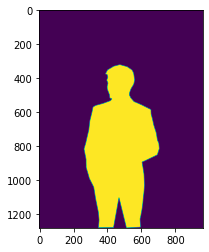

In [44]:
plt.imshow(mask[..., 0])

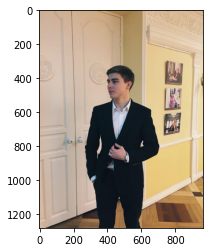

In [45]:
plt.imshow(img[..., [2,1,0]])

In [46]:
img.shape

(1280, 960, 3)

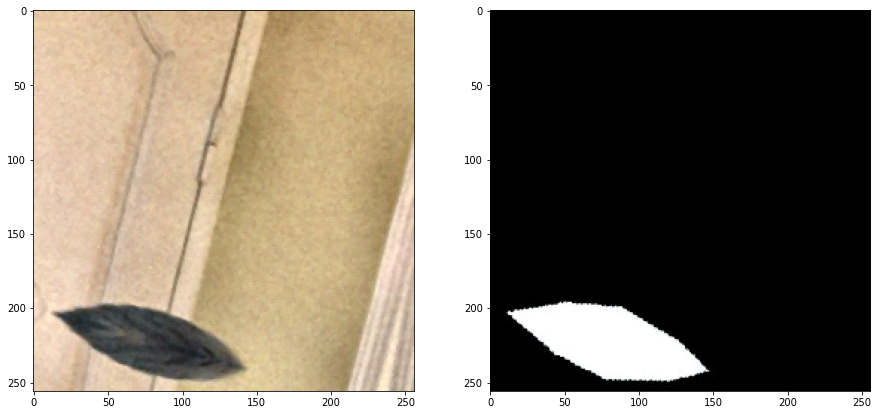

In [53]:
augmentation = strong_aug(p=1.0)


data = {'image': img.astype('uint8'), 'mask': mask}
augmented = augmentation(**data)
crop_img, crop_mask = augmented["image"], augmented["mask"]

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 15))
axes[0].imshow(crop_img[..., [2,1,0]])
axes[1].imshow(crop_mask)

plt.show()